# Dataquest Binary Classification Project
Using data from LendingTree, the goal is to build a machine learning model that accurately predicts (TPR>0.5, FPR<0.07) if a borrower will pay off their loan on time.

In [213]:
#import packages
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5,3)

#read in data, print first row
loans = pd.read_csv("loans_2007.csv")
loans.drop_duplicates()
print(loans.iloc[0])

C:\Users\colin\AppData\Local\Temp\ipykernel_8144\440724700.py:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  loans = pd.read_csv("loans_2007.csv")


id                                1077501
member_id                       1296599.0
loan_amnt                          5000.0
funded_amnt                        5000.0
funded_amnt_inv                    4975.0
term                            36 months
int_rate                           10.65%
installment                        162.87
grade                                   B
sub_grade                              B2
emp_title                             NaN
emp_length                      10+ years
home_ownership                       RENT
annual_inc                        24000.0
verification_status              Verified
issue_d                          Dec-2011
loan_status                    Fully Paid
pymnt_plan                              n
purpose                       credit_card
title                            Computer
zip_code                            860xx
addr_state                             AZ
dti                                 27.65
delinq_2yrs                       

## Part 1: Cleaning data

Drop columns that contain redundant information, aren't useful for modeling, require too much processing to make useful, or leak information from the future.

In [214]:
#grade collinear w/ int_rate
drop_list1=["id", "member_id", "funded_amnt", "funded_amnt_inv", "grade", "sub_grade", "emp_title", "issue_d"]
drop_list2=["zip_code", "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", "total_rec_prncp"]
drop_list3=["total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee", "last_pymnt_d", "last_pymnt_amnt"]
drop_list4=['initial_list_status', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens']
columns_to_drop=drop_list1+drop_list2+drop_list3+drop_list4
loans = loans.drop(columns_to_drop, axis=1)

Drop columns with only one value.

In [215]:
drop_columns = []
for col in loans.columns:
    if len(loans[col].dropna().unique()) == 1:
        print(col)
        loans=loans.drop(col, axis=1)

pymnt_plan


Our target column will be ```loan_status```. 

In [216]:
loans['loan_status'].value_counts()

Fully Paid                                             34085
Charged Off                                             5662
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Current                                                   19
Late (31-120 days)                                         9
In Grace Period                                            8
Late (16-30 days)                                          2
Default                                                    1
Name: loan_status, dtype: int64

Only the Fully Paid and Charged Off values describe the final outcome of the loan. The other values describe loans that are still ongoing and where the jury is still out on if the borrower will pay back the loan on time or not. 

As such, we drop all other values and then make the variable binary where Fully Paid = 1 and Charged Off = 0. 

In [217]:
loans = loans[(loans['loan_status'] == "Fully Paid") | (loans['loan_status'] == "Charged Off")]
loans = loans.replace({"loan_status" : {"Fully Paid": 1, "Charged Off": 0}})
loans['loan_status'].value_counts()

1    34085
0     5662
Name: loan_status, dtype: int64

Before dropping missing data, let's take stock of our dimensions.

In [218]:
loans.shape

(39747, 23)

Now let's look at our null counts.

In [219]:
null_counts = loans.isnull().sum()
print(null_counts[null_counts>0])

emp_length              1076
title                     11
revol_util                50
last_credit_pull_d         2
pub_rec_bankruptcies     697
dtype: int64


```pub_rec_bankruptcies``` has low variation...

In [220]:
loans.pub_rec_bankruptcies.value_counts()

0.0    37366
1.0     1677
2.0        7
Name: pub_rec_bankruptcies, dtype: int64

... which makes it a poor choice for a feature, so we'll drop that column entirely. While ```emp_length``` has a lot of null counts, it could be important for our analysis so we'll keep it and just drop rows with missing values there. We'll do the same for the rest of the columns with missing values.

In [221]:
loans = loans.drop("pub_rec_bankruptcies", axis=1)
loans = loans.dropna(axis=0)

Let's now examine non-numeric data.

In [222]:
object_columns_df = loans.select_dtypes(include=["object"])
print(object_columns_df.iloc[0])

term                     36 months
int_rate                    10.65%
emp_length               10+ years
home_ownership                RENT
verification_status       Verified
purpose                credit_card
title                     Computer
addr_state                      AZ
earliest_cr_line          Jan-1985
revol_util                   83.7%
last_credit_pull_d        Dec-2016
Name: 0, dtype: object


Some of the columns seem like they represent categorical values, but we should confirm by checking the number of unique values in those columns:
1. ```home_ownership```: home ownership status, can only be 1 of 4 categorical values according to the data dictionary,
2. ```verification_status```: indicates if income was verified by Lending Club,
3. ```emp_length```: number of years the borrower was employed upon time of application,
4. ```term```: number of payments on the loan, either 36 or 60,
5. ```addr_state```: borrower's state of residence,
6. ```purpose```: a category provided by the borrower for the loan request,
7. ```title```: loan title provided by the borrower.

In [223]:
cols = ['home_ownership', 'verification_status', 'emp_length', 'term', 'addr_state', 'purpose', 'title']
for c in cols:
    print('--- ' + c + '-----\n' + loans[c].value_counts().head(15).to_string() +'\n\n')

--- home_ownership-----
RENT        18451
MORTGAGE    17226
OWN          2836
OTHER          96
NONE            3


--- verification_status-----
Not Verified       16466
Verified           12354
Source Verified     9792


--- emp_length-----
10+ years    8886
< 1 year     4573
2 years      4387
3 years      4090
4 years      3429
5 years      3279
1 year       3236
6 years      2224
7 years      1770
8 years      1480
9 years      1258


--- term-----
 36 months    28234
 60 months    10378


--- addr_state-----
CA    6903
NY    3707
FL    2776
TX    2672
NJ    1821
IL    1486
PA    1480
VA    1377
GA    1357
MA    1312
OH    1190
MD    1033
AZ     831
WA     806
CO     768


--- purpose-----
debt_consolidation    18239
credit_card            4999
other                  3821
home_improvement       2883
major_purchase         2108
small_business         1779
car                    1497
wedding                 934
medical                 668
moving                  557
house             

The ```home_ownership```, ```verification_status```, ```emp_length```, and ```term``` columns all contain multiple discrete values.  

```title``` is highly similar to ```purpose```, which has less discrete values, so we will drop it. We'll also drop ```addr_state```, as  creating 50 dummy columns would make our dataframe much larger and slow down how quickly the code runs.

In [224]:
loans=loans.drop(['title', 'addr_state'], axis=1)

We should clean the emp_length column and treat it as a numerical one since the values have ordering (2 years of employment is less than 8 years).

In [225]:
mapping_dict = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0
    }
}

loans = loans.replace(mapping_dict)

```revol_util``` (revolving line utilization rate or the amount of credit the borrower is using relative to all available credit) and ```int_rate``` are numeric and must be converted.

In [226]:
for c in ['revol_util', 'int_rate']: 
    loans[c] = loans[c].str.rstrip("%").astype("float")

Lastly, some of the columns contain date values that would require a good amount of feature engineering for them to be potentially useful:
1. ```earliest_cr_line```: The month the borrower's earliest reported credit line was opened,
2. ```last_credit_pull_d```: The most recent month Lending Club pulled credit for this loan.

In [227]:
loans = loans.drop(["last_credit_pull_d", "earliest_cr_line"], axis=1)

We'll now create dummy variables for the ```home_ownership```, ```verification_status```, ```purpose```, and ```term``` columns

In [228]:
cat_columns = ["home_ownership", "verification_status", "purpose", "term"]
dummy_df = pd.get_dummies(loans[cat_columns])
loans = pd.concat([loans, dummy_df], axis=1)
loans = loans.drop(cat_columns, axis=1)

Now that our data has been cleaned, it's now time to start building our model.


## Part 2: Logistic regression model
Our goal is to generate features from data, which we can feed into a machine learning algorithm. The algorithm will make predictions about whether or not a loan will be paid off on time, which is contained in the ```loan_status``` column of the clean dataset.

First, let's build a logistic regression model that predicts the target variable, ```loan_status```. We will use a 10-fold cross validation, where each prediction is obtained when that observation is in the test, not train, set. 

In [229]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
lr = LogisticRegression(max_iter=1000)
train_cols = loans.columns.drop("loan_status")
features = loans[train_cols]
target = loans["loan_status"]
#predictions are when each data is in test set
predictions=cross_val_predict(lr, features, target, cv=10)

Now let's build a function to examine the accuracy of our model. 

In [230]:
def model_accuracy(predictions, actuals):
    # False positives.
    fp_filter = (predictions == 1) & (actuals == 0)
    fp = len(predictions[fp_filter])

    # True positives.
    tp_filter = (predictions == 1) & (actuals == 1)
    tp = len(predictions[tp_filter])

    # False negatives.
    fn_filter = (predictions == 0) & (actuals == 1)
    fn = len(predictions[fn_filter])

    # True negatives
    tn_filter = (predictions == 0) & (actuals == 0)
    tn = len(predictions[tn_filter])
    # Rates
    tpr = tp  / (tp + fn)
    fpr = fp  / (fp + tn)
    
    return {'tpr': tpr, 'fpr': fpr}

model_accuracy(predictions, target)

{'tpr': 0.9993372895141127, 'fpr': 0.9988919667590028}

**Yikes!** The false positive rate is almost 100%. This is what we'd expect from a model that predicts all 1's, and is due to the imbalance in our target.

In [231]:
target.value_counts()

1    33197
0     5415
Name: loan_status, dtype: int64

There are a few ways to get a classifier to correct for imbalanced classes. The two main ways are:
1. Use over/undersampling to ensure that the classifier gets input that has a balanced number of each class. 
2. Tell the classifier to penalize misclassifications of the less prevalent class more than the other class. 

The second method is easier to implement using scikit-learn, so we'll do that below and compare the accuracy metrics.


In [232]:
lr = LogisticRegression(class_weight="balanced", max_iter=1000)
predictions=cross_val_predict(lr, features, target, cv=10)

model_accuracy(predictions, target)

{'tpr': 0.5153176491851673, 'fpr': 0.33240997229916897}

A 33% FPR is better, but still not good enough. Let's iterate through different manual penalty settings to see if we can do better.

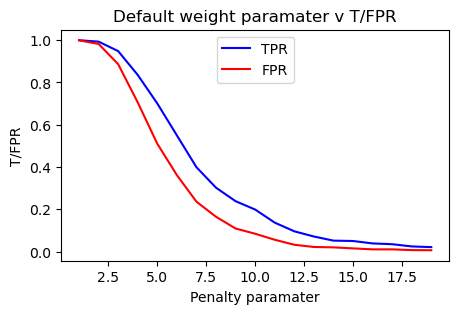

tpr    0.198964
fpr     0.08458
Name: 10, dtype: object


In [236]:
df=pd.DataFrame(index=range(1,20),columns=['tpr','fpr'])
for n in range(1,20):
    lr = LogisticRegression(class_weight={0: n, 1: 1}, max_iter=1000)
    predictions=cross_val_predict(lr, features, target, cv=10)
    accuracy_metrics = model_accuracy(predictions, target)
    df.loc[n,'tpr']=accuracy_metrics['tpr']
    df.loc[n,'fpr']=accuracy_metrics['fpr']  
    
# Plot results
fig, ax1 = plt.subplots()
ax1.plot(df.index, df['tpr'], 'b-', label='TPR')
ax1.plot(df.index, df['fpr'], 'r-', label='FPR')
ax1.set_xlabel('Penalty paramater')
ax1.set_ylabel('T/FPR')
ax1.legend(loc='upper center')
plt.title('Default weight paramater v T/FPR')
plt.show()

print(df.loc[10])

Based on the above chart, setting the class weight to 10 for target==0 seems best, as the TPR is 19.9%, but the FPR is 8.5%. Still, that's quite a price to pay for reducing the FPR. While we have fewer false positives, we're also missing opportunities to fund more loans and potentially make more money. Given that we're approaching this as a conservative investor, this strategy makes sense, but it's worth keeping in mind the tradeoffs.

Let's see if a different, more complex algorithm -- the random forest -- can give us better results...

In [235]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight="balanced", random_state=1)
predictions = cross_val_predict(rf, features, target, cv=10)
model_accuracy(predictions, target)

{'tpr': 0.9992770431063048, 'fpr': 0.9964912280701754}

Look's like much the same. All told, our best bet is a logistic regression with a 10x1 default weight paramater. This results in a TPR = 19.9% and an FPR = 8.5%. To earn money, an investor must set the interest rate high enough to offset defaults on an expected 8.4% of loans extended.